# Twitter Sentiments

------

A deep dive into sentiment analysis from Twitter users
and their perception of certain brands and products. A
project aimed at product managers to increase their
efficiency by making both benefits and issues stand out
directly from the mouths of their customers.

![picture](./img/twitter_title.png)

## Goals

------

### Understand

Use the content and meaning of words to evaluate some
part of what's being said in a given tweet; as well -
determine what words can be outright ignored throughout
the process to bring efficiency and strength to the
model at hand.

### Classify

Create a model that is able to correctly classify the
sentiments expressed in any given tweet using the
content within to categorize it as any of positive,
negative, or neutral/no emotion.

### Predict

Take in new tweet information as it becomes available
to utilize a model that can draw conclusions from
existing data to allow product managers to quickly and
efficiently place their focus where it counts.


## Business Case:

------

Social media is a powerful tool for connecting with
your customer base.

Customer feedback is critical in the success of both
products and businesses, but often is difficult,
expensive, or unwieldy to collect.

Twitter is frequently a place for people to vent their
frustrations or joys of products and services and is a
mostly-public tool that can be leveraged in our favor
to get a strong overview of what the primary issues may
be, but with unimagineable numbers of tweets being sent
out on a daily, or even hourly basis, gathering the
general sentiment of any number of these tweets is all
but impossible for a team of any size.

It is imperative that this process be automated to the
best of any computer's ability in order to obtain the
most in-depth understanding of a market's emotions.

By categorizing these sentiments, it becomes much more
possible to narrow down to any number of tweets for
review.


## Data Overview:

------

This data set was provided by Flatiron School and
sourced through
[data.world](https://data.world/),
provided
[here](https://data.world/crowdflower/brands-and-product-emotions).
The data contains the brand being discussed as well as
general sentiments for each of 9,092 tweets alongside
their original content, as derived by a human.  
These tweets are centered around attendees of the
South by Southwest (SXSW) electronics expo and are
categorized as either negative, positive, or neutral in
regards to the emotions being expressed.


## Importing Packages

------

There are a lot of powerful packages that Python has
access to that we will be using in this process.


In [2]:
# basic data science packages for analysis
import pandas as pd
import numpy as np
# basic regular expression pcakage
import re

# used for outputting tables from python code
from IPython.display import Markdown

# used for increasing processing efficiency and saving
# or loading the final model when it's completed
from joblib import parallel_backend, dump, load

# text processing packages
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import \
            CountVectorizer,TfidfVectorizer
# scoring and testing packages for testing models
from sklearn.metrics import f1_score, make_scorer, \
            plot_confusion_matrix

# models and model testing
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
            GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# plotting/graphing functions and theming
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# word cloud visualization
from wordcloud import WordCloud

# custom processing and visualizing functions
from code.cleaner import preprocess
from code.viz import word_plot
# custom scoring functions
from code.scoring import custom_scorer

sns.set()

## Examining Our Features & Targets

------

In order to start our process, we need to bring in our
data and verify what's in it. We'll start by loading
the data and checking its output.

In [3]:
sentiments = pd.read_csv(
    './data/judge-1377884607_tweet_product_company.csv',
    encoding='ISO-8859-1')
sentiments.tail()

tweet_text  \
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
9088                            iPad   
9089                             NaN   
9090                             NaN   
9091                             NaN   
9092                             NaN   

     is_there_an_emotion_directed_at_a_brand_or_product  
9088                                   Positive emotion  
9089                 No emotion toward brand or product  
9090                 No emotion toward brand or product  
9091                 No emotion toward brand or product  
9092                 No emotion toward brand or product

Our data seems pretty straightforward, there's the
tweet body, what the tweet is directed at, and what
emotion the tweet is expressing. The column names are
really and somewhat confusing. We'll start off by
renaming them.

In [4]:
sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [5]:
sentiments.shape

(9093, 3)

In [6]:
sentiments['tweet_text'].isna().sum()

1

There's one empty tweet so we'll go ahead and delete
that and check the sentiment counts.

In [7]:
sentiments.dropna(subset=['tweet_text'],inplace=True)
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

It looks like there are some tweets that were
classified as "I can't tell" which won't be very
helpful in our process.

Here, we'll split off the sentiments listed as "I can't
tell" into their own dataframe and drop them from the
original.

In [8]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

///////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////
///////////////////////////////////////////////////////////////////////
<!-- ## Preprocessing



We discovered that there were several words that occurred frequently across all sentiments, and we needed to remove them to enhance our model's effectiveness. By removing these less meaningful words, we isolated the significant keywords that have the most impact on each sentiment. The charts display the top ten most frequent words in each sentiment, after removing these less impactful words. We also found it interesting that the word "like" was commonly used in negative tweets in our dataset. -->

## Preprocessing

For visualization, we'll go ahead and plot out all of
the words that are in the data set into a word cloud so
we can get a good grasp of what our data contains. As
a first step, we'll remove what are known as "stop
words" that don't really hold any meaning on their own.

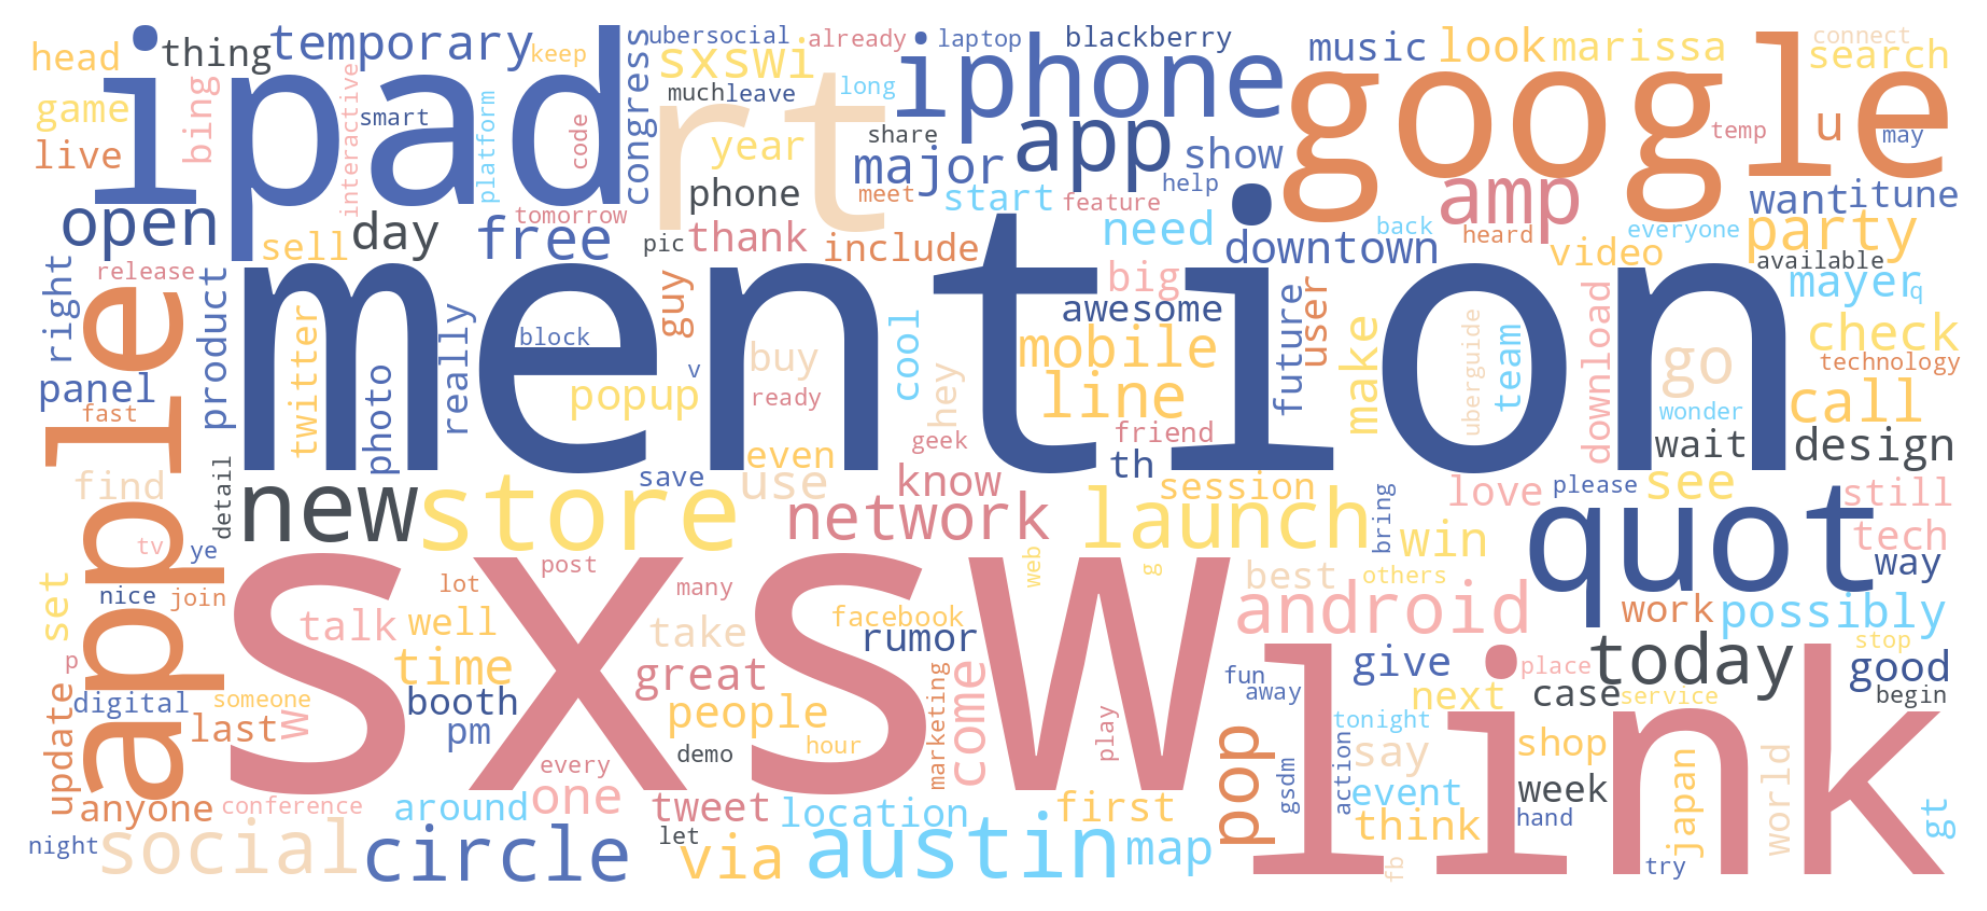

In [10]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'], ret_tokens=True)

# This is the palette used in our associated
# presentation, available at a link later on
raw_map = [
        '#3f5896', '#494f56', '#4f6ab3',
        '#5773b8', '#76d3fb', '#db868e',
        '#e28a5c', '#f4d9bc', '#f7b2b0',
        '#fddf75', '#ffcc66'
        ]
canvamap = ListedColormap(raw_map)

wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='#ffffff'
).generate(' '.join(sentiments['tokenized']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

There seem to be a lot of words repeated a lot of
times, so we'll want to go through and add those words
to list for removal.

In [11]:
sw = stopwords.words('english')
specific_words = [
    '@mention','link','sxsw','#sxsw','@sxsw'
]
# ^^ these are the original extended stop words from
# initial data

# the prior output and domain knowledge lead us to the
# following words as well
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

Just to too how these tweets will look after removing
the words that don't seem helpful, we'll output the
first five entries here.

In [12]:
preprocess(sentiments.head()['tweet_text'],sw)

['@wesley g hr tweet #rise dead need upgrade plugin station',
 '@jessedee know @fludapp awesome likely appreciate design also give free t',
 '@swonderlin wait #ipad also sale',
 'hope year festival crashy year',
 '@sxtxstate great stuff fri marissa mayer tim reilly tech book conference amp matt mullenweg wordpress']

In [13]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

Next, we'll take a look at some of the words that are
shared between all of the sentiments.

Index(['get', 'launch'], dtype='object')


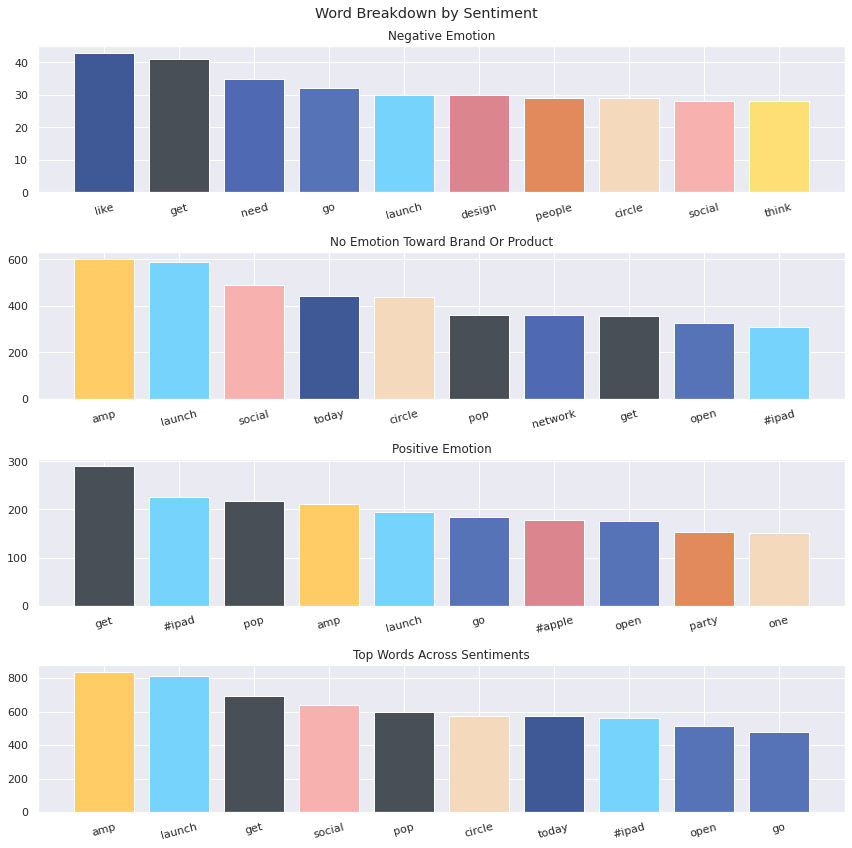

In [14]:
freq_words = word_plot(sentiments, 'sentiment', 'tokens',
    n_words=10, theme=raw_map)
print(freq_words[1])

### Splitting the Data

Since we're starting to take influence from our data
and using that to manipulate models, we'll want to
split everything into a training set and a testing set.

In [15]:
X = sentiments[['tokenized','tokens']]
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

# Because we need to have this data in a single
# dataframe frequently later, we'll go ahead and merge
# the frames back together as train and test instead of
# X_train and X_test etc. 

train = X_train.merge(
    y_train,left_index=True,right_index=True
    )
test = X_test.merge(
    y_test,left_index=True,right_index=True
    )

Here, we'll begin the process of finding and removing
the words that appear frequently across all sentiments.
These words won't be useful in categorizing our data
since they'll have similar weights across the board.

Index(['#ipad', 'get', 'launch', 'line'], dtype='object')


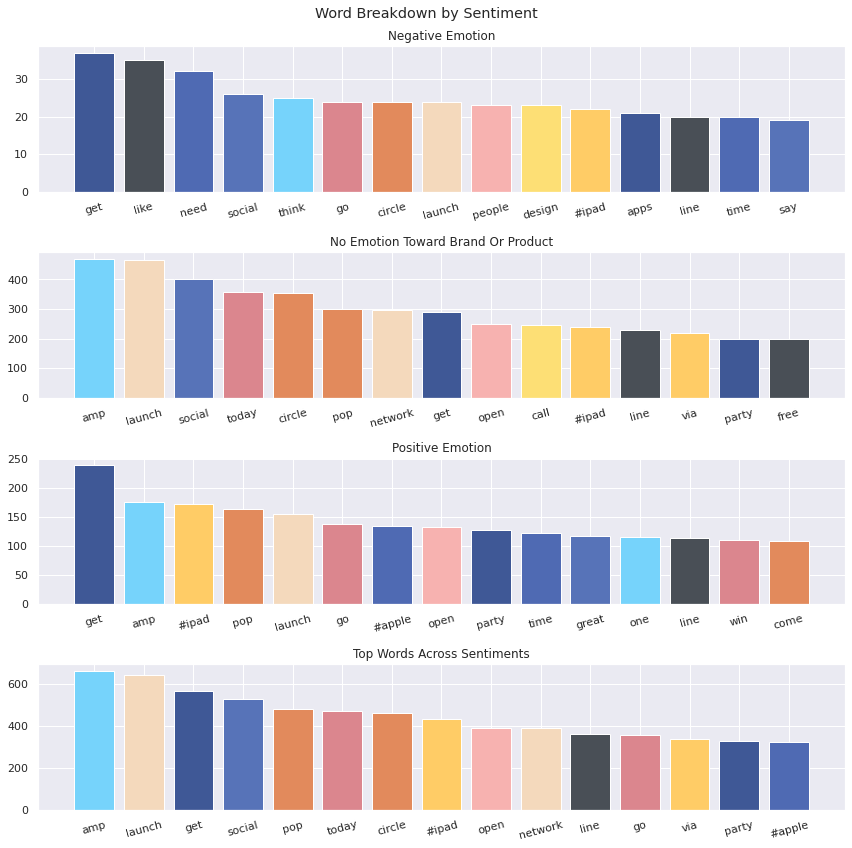

In [16]:
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Since we still have words in all of the categories,
we'll repeat this process until we don't - plotting out
a new graph each time.

Index(['amp', 'go', 'social'], dtype='object')


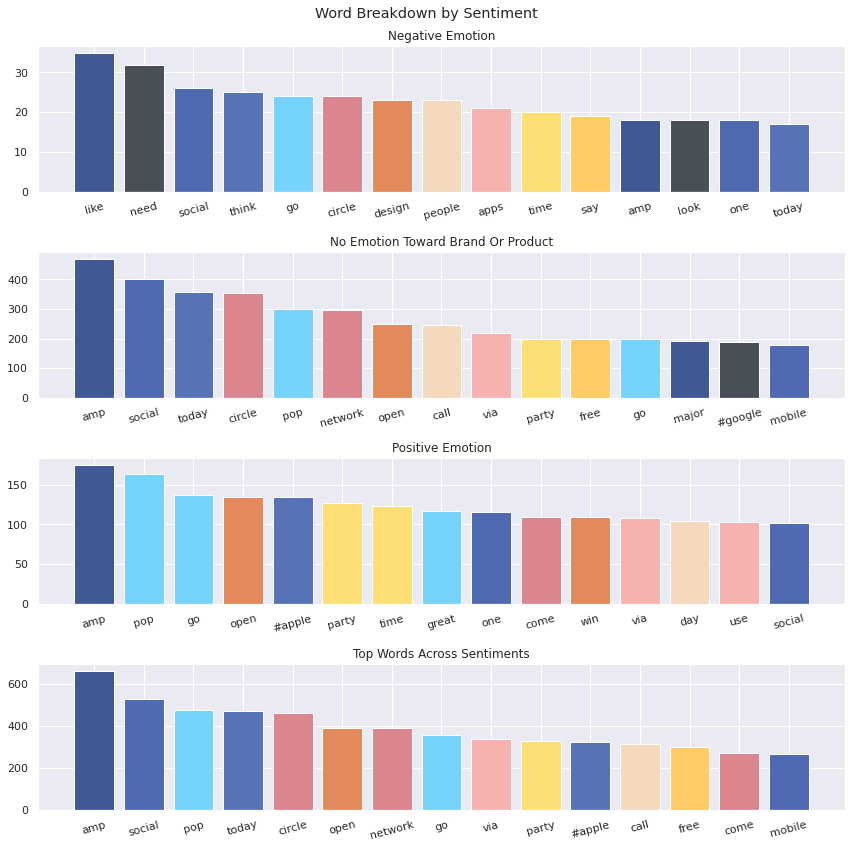

In [17]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Index(['today'], dtype='object')


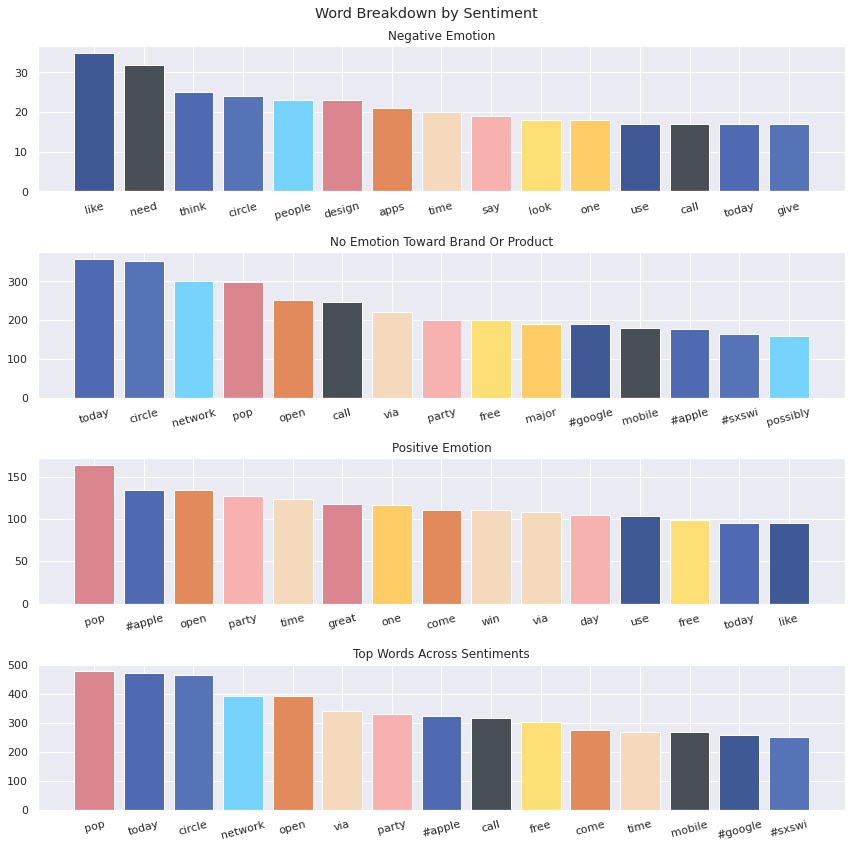

In [18]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Index([], dtype='object')


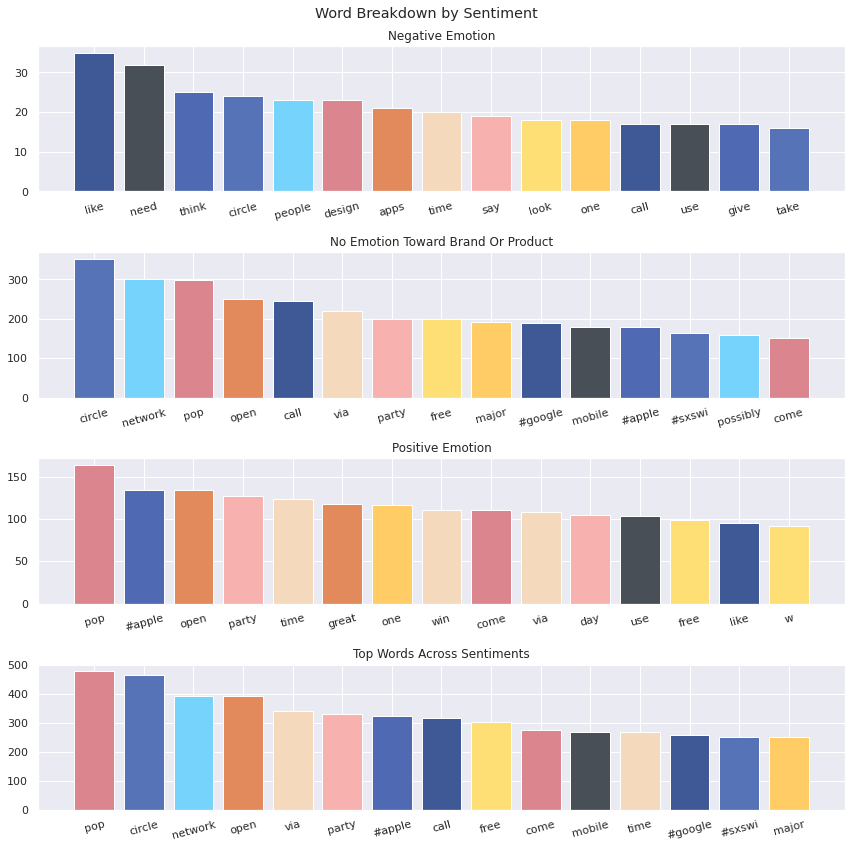

In [19]:
sw.extend(freq_words[1])
train['tokenized'], train['tokens'] = preprocess(train['tokenized'],sw,ret_tokens=True)
freq_words = word_plot(train,'sentiment','tokens',
    n_words=15, theme=raw_map)
print(freq_words[1])

Great! No shared words across sentiments in the top
slots.

We'll put up another visual representing the words in
each sentiment to get a decent gauge on what might be
having the most gravity.

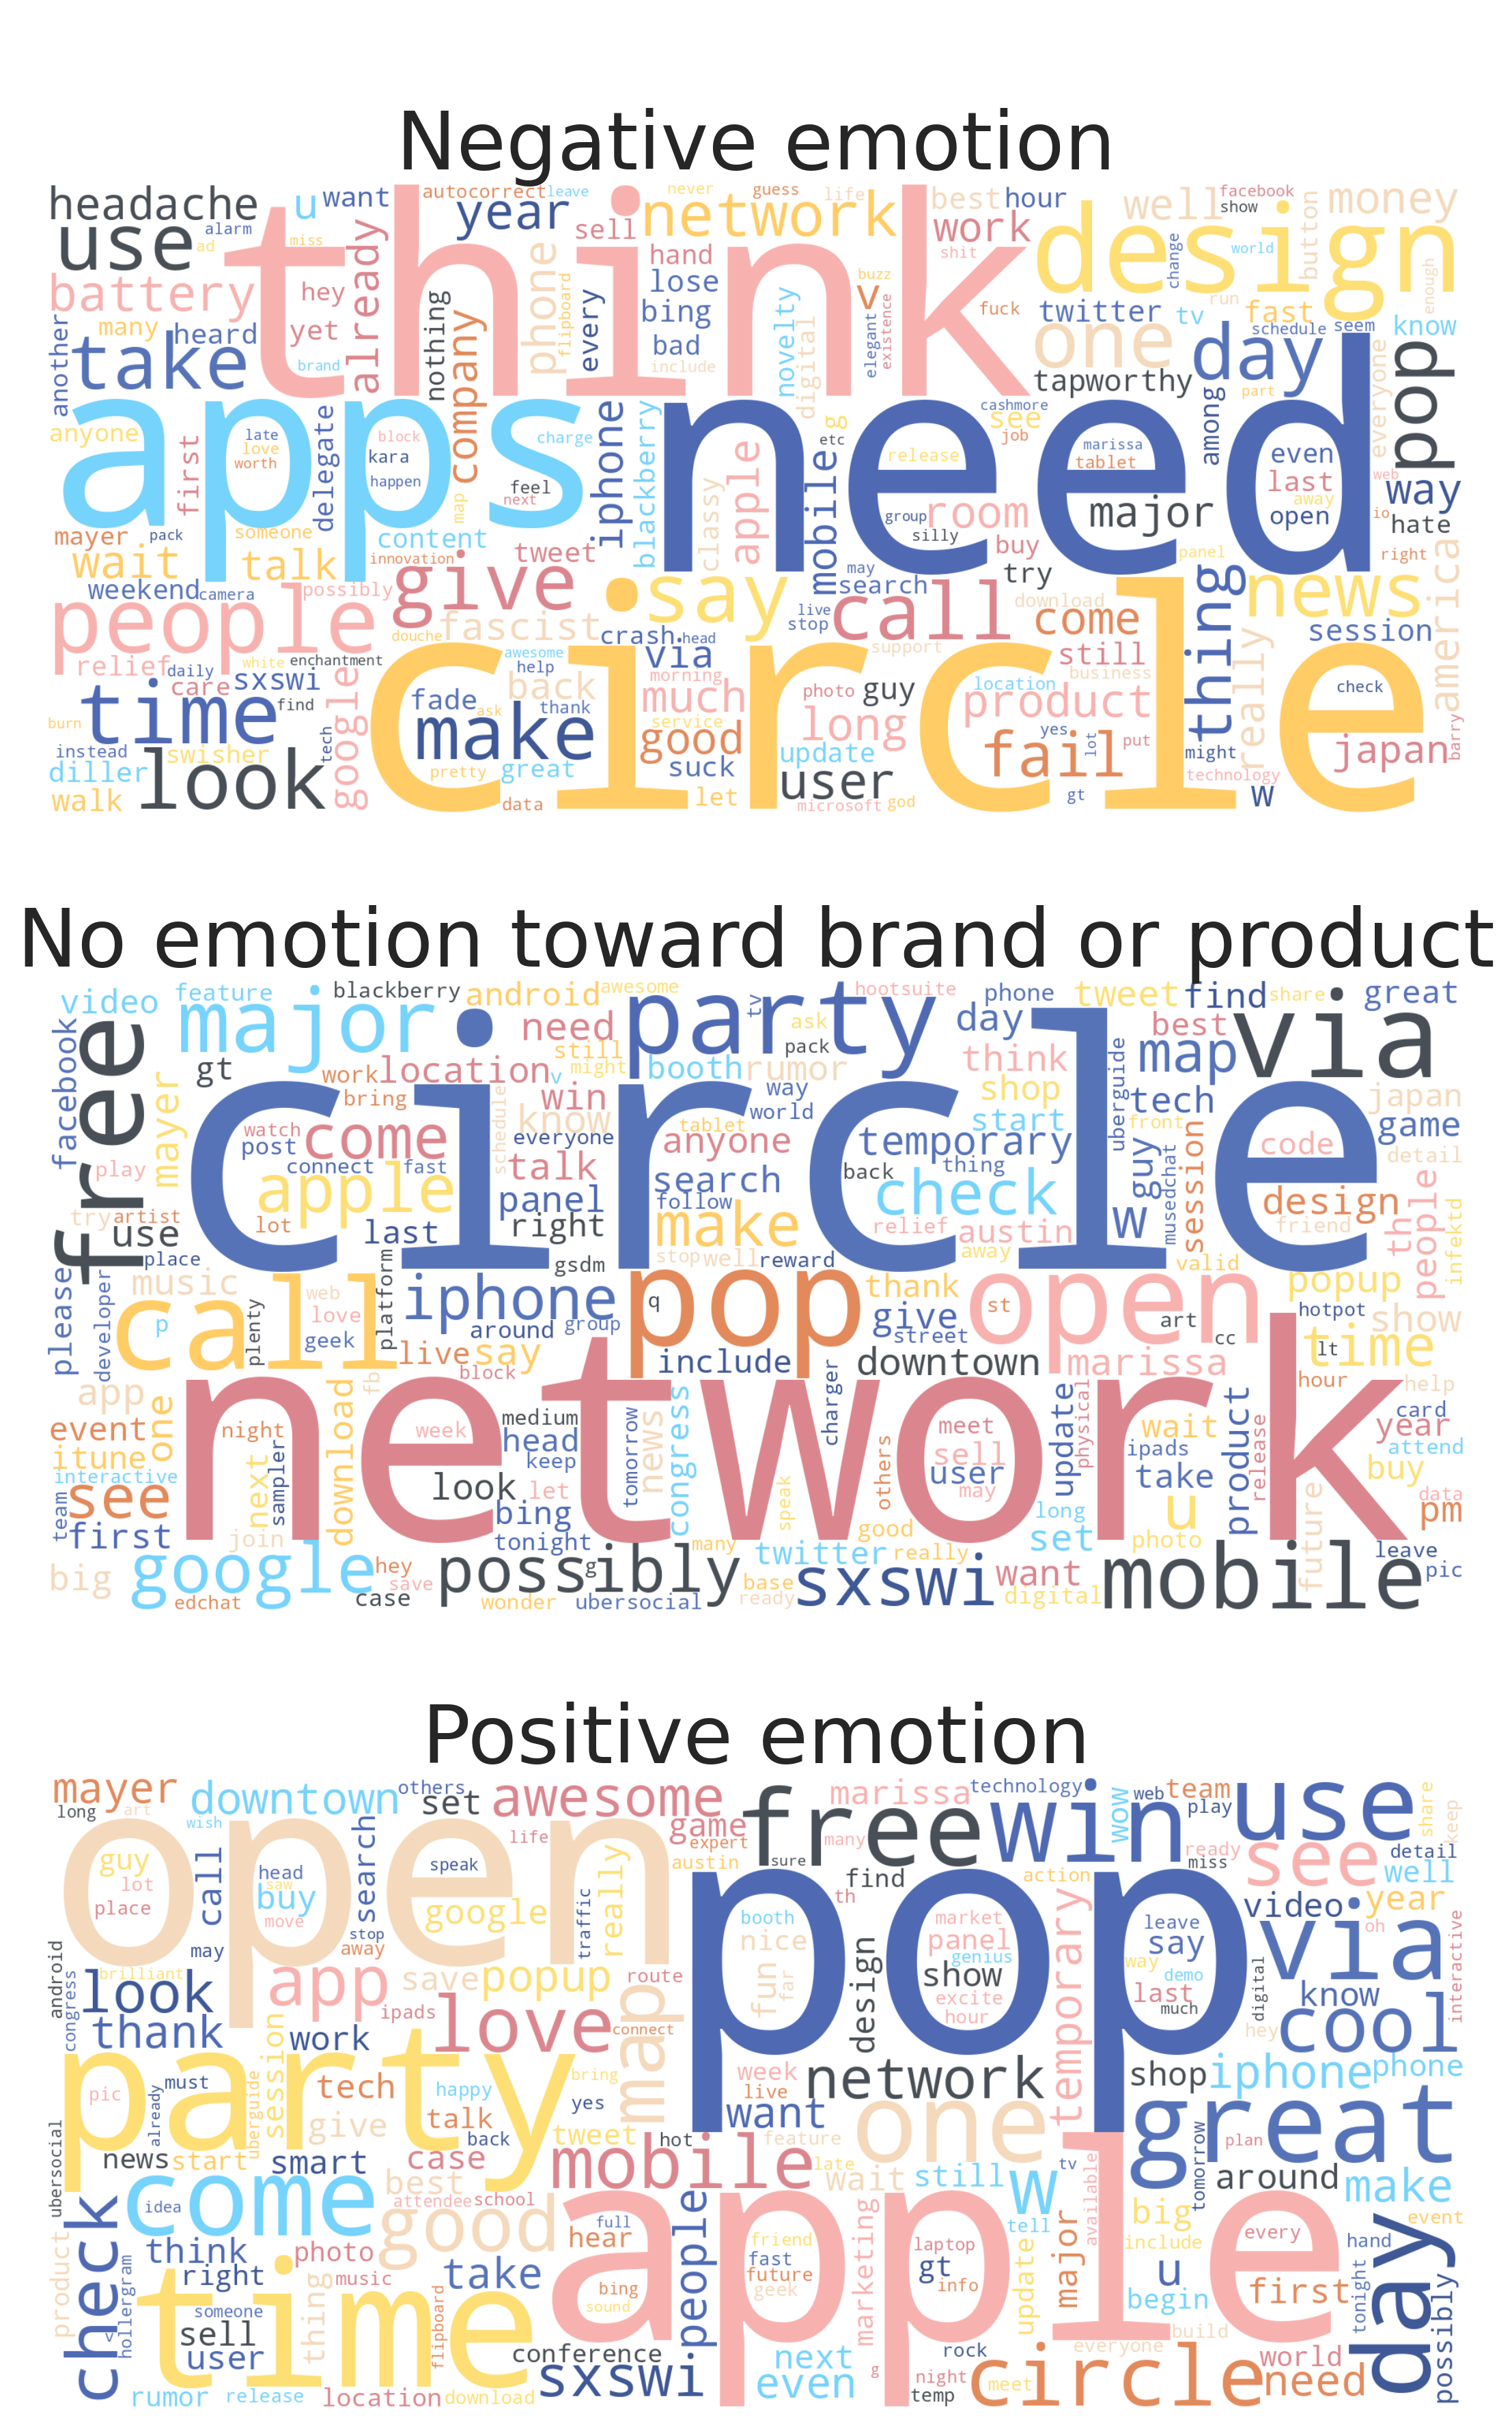

In [20]:
fig, ax = plt.subplots(3,1,figsize=(10,14),dpi=250)
for i, emo in enumerate(train['sentiment'].unique()):
    tmp_ = train[train['sentiment'] == emo]
    ax_ = ax[i]
    wordcloud = WordCloud(
        collocations=False, width=1800,height=800,
        background_color="#ffffff00",
        colormap=canvamap
        ).generate(' '.join(tmp_['tokenized']))
    ax_.set_title(f"\n{emo}",fontsize=34)
    ax_.imshow(wordcloud, interpolation='bilinear')
    ax_.axis('off')
plt.tight_layout(pad=0)

It looks like there are a few things shared between
neutral and the other categories but not between all of
the categories. This is still useful since a word that
appears in the neutral and negative sentiments would
be leveraging against it being in positive.

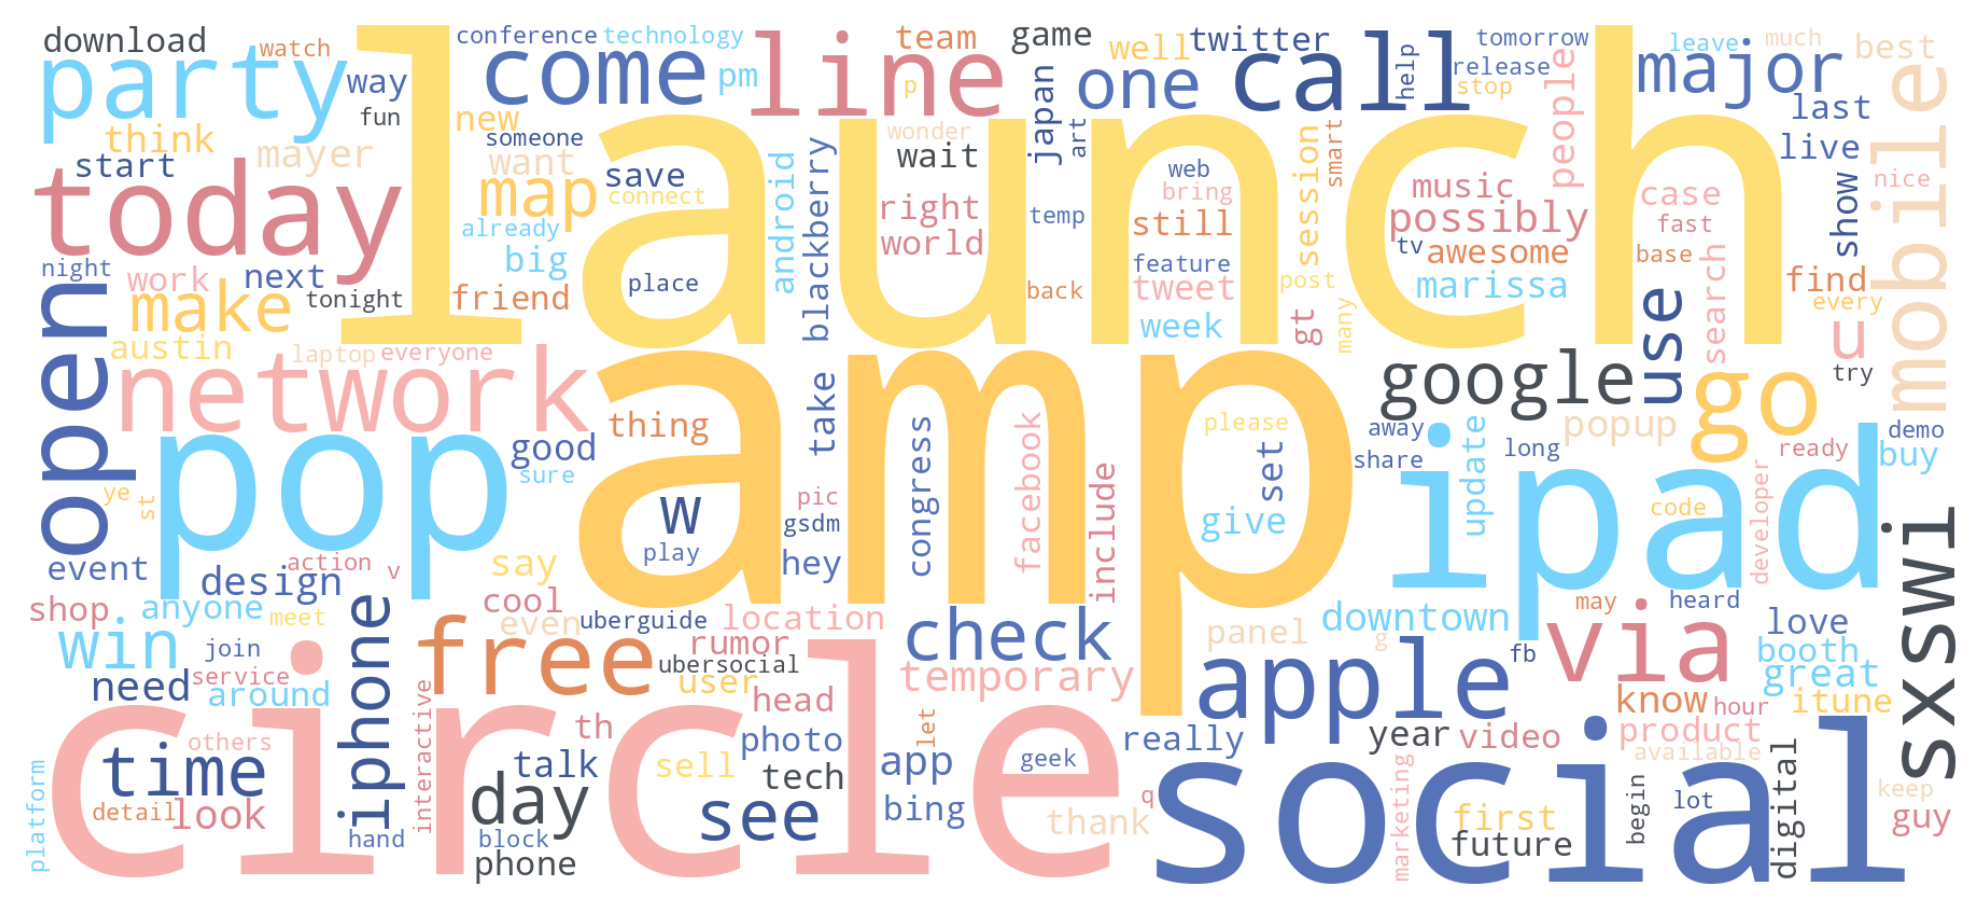

In [22]:
fig, ax = plt.subplots(1,1,figsize=(10,8),dpi=250)
wordcloud.generate(' '.join(sentiments['tokenized']))
ax.imshow(wordcloud,interpolation='bilinear')
plt.axis('off');

We can see that the word "Circle" appears at a high
volume in every category. Looking through the data,
this is because Google launched a social network called
"Circle" that was a large topic during the SXSW event
that was taking place during the time of our dataset's
collection. It would probably be worth it to go ahead
and drop this.

In [23]:
sw.extend(['circle'])
train['tokenized'],train['tokens'] = \
    preprocess(train['tokenized'],sw,ret_tokens=True)

In order for our models to use the data we have, we
need to turn them into counts and vectors for
processing, so we'll go ahead and run our test data
through the preprocessing step here so that it can be
vectorized at the same time.

We'll use TF-IDF vectorization here to make sure the
counts are properly weighted based on their frequency
across the data set.

In [24]:
test['tokenized'], test['tokens'] = preprocess(test['tokenized'],sw,ret_tokens=True)
tfidf = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

train_tfidf = tfidf.fit_transform(train['tokenized'])
test_tfidf = tfidf.transform(test['tokenized'])

# In order to run our modeling functions, the vectors
# need to be expressed as dataframes
train_vec = pd.DataFrame(train_tfidf.toarray(),columns=tfidf.get_feature_names())
test_vec = pd.DataFrame(test_tfidf.toarray(),columns=tfidf.get_feature_names())

## Creating the Models

------

Here, we will try several types of models that are
known to be useful in language processing.

Because of a large imbalance in our data, remember that
our entire data set was ~60% neutral sentiment and only
~6.4% negative sentiment, we'll neet to over-sample the
positive and negative sentiments. For this process, we
are sampling the neutral targets at 50% of the data and
the positive or negative targets as the other 50% at
25% each.

In [32]:
## For the purposes of presentation, this section has
## been commented out. The procedure has been left here
## to show the steps used, but the model is saved as a
## pkl file for reproducibility, as the model fitting
## process is extremely long across a multi-part grid
## search.

# rfc = RandomForestClassifier(n_jobs=-2,random_state=13)
# knc = KNeighborsClassifier(n_jobs=-2)
# mnb = MultinomialNB()
# svc = SVC(random_state=13)

# scoring = make_scorer(custom_scorer)

# rfc_grid = {
#     'max_depth':[15,20,25,30],
#     'min_samples_split':[10,15,20]
# }
# knc_grid = {
#     'n_neighbors':[3,5,7,9]
# }
# mnb_grid = {
# }
# svc_grid = {
#     'kernel':['poly','rbf'],
#     'degree':[3,4]
# }

# rfc = GridSearchCV(
#     rfc,rfc_grid,
#     scoring=scoring
# )
# knc = GridSearchCV(
#     knc,knc_grid,
#     scoring=scoring
# )
# mnb = GridSearchCV(
#     mnb,mnb_grid,
#     scoring=scoring
# )
# svc = GridSearchCV(
#     svc,svc_grid,
#     scoring=scoring
# )

# classifiers = [rfc,knc,mnb,svc]

# majority_length = len(train[train['sentiment'] == 'No emotion toward brand or product'])
# sub_majority_length = len(train[train['sentiment'] == 'Positive emotion'])

# if sub_majority_length*2 > majority_length:
#     scale_size = sub_majority_length*2
# else:
#     scale_size = majority_length

# sm_dict = {
#     "No emotion toward brand or product"    : int(scale_size),
#     "Positive emotion"                      : int(scale_size*0.5),
#     "Negative emotion"                      : int(scale_size*0.5)
# }

# o = SMOTE(random_state=13)
# # o_grid = {
# #     'sampling_strategy':['minority','auto',sm_dict]
# # }
# o_grid = ['minority','auto',sm_dict]

# # o = GridSearchCV(
# #     o,o_grid,
# #     scoring=scoring
# # )
# pipe = imbPipeline(
#     steps=[
#         ('o',o),
#         ('search',DummyClassifier())
#     ]
# )

# grid = [
#     {'o':['passthrough'],
#      'search':[*classifiers]},
#     {'o':[o],
#     'o__sampling_strategy':o_grid,
#     'search':[*classifiers]}
# ]

In [33]:
# gs = GridSearchCV(
#     pipe,grid,scoring=scoring,
#     verbose=3
# )

Here, the grid search is performed across EVERY item
defined above. This process runs through thousands of
calculations on the entirety of our training data. For
reproducibility, the model is then saved as
best_estimator.pkl so that this process doesn't need to
be re-run every time.

In [34]:
# # even with parallel backend, this process takes ~45
# # minutes to run on 23 cores. 
# with parallel_backend('threading',n_jobs=-2):
#     gs.fit(train_vec,train['sentiment'])

The best estimator determined by this process was a
pipeline with default values for SMOTE and for SVC.

In [26]:
# best_top   = gs.best_estimator_.steps[0][1]
# best_inner = gs.best_estimator_['search'].best_estimator_
# best_model = imbPipeline(
#     steps=[
#         ('scaler',best_top),
#         ('model',best_inner)
#     ]
# )
#  
# # dump() is used to output the estimator as a file so
# # that it can be loaded later. 
# dump(best_model,'./data/best_estimator.pkl')
# # this will load our preserved model from earier 
best_model = load('./data/best_estimator.pkl')

Here, we'll perform a test against our training data to
see how we're measuring up and we'll take the mean of
our f1 score on our positive and negative targets,
since we want to put a lot more focus on those
categories, those being the ones that would require
addressing the most.

In [27]:
y_pred = best_model.predict(train_vec)
train['sentiment'].value_counts(), \
(fs_arr := f1_score(y_pred,train['sentiment'],average=None)), \
fs_arr[1:].mean()

(No emotion toward brand or product    4310
 Positive emotion                      2382
 Negative emotion                       456
 Name: sentiment, dtype: int64,
 array([0.79890311, 0.90939044, 0.8579932 ]),
 0.8836918210447277)

Our predictions on our training data look pretty decent
with our model picking up on around 88% of our positive
and negative values.

In [28]:
test_pred = best_model.predict(test_vec)
test['sentiment'].value_counts(), \
(fs_arr := f1_score(test_pred,test['sentiment'],average=None)), \
fs_arr[1:].mean()

(No emotion toward brand or product    1078
 Positive emotion                       596
 Negative emotion                       114
 Name: sentiment, dtype: int64,
 array([0.36866359, 0.74495742, 0.57624113]),
 0.6605992764749453)

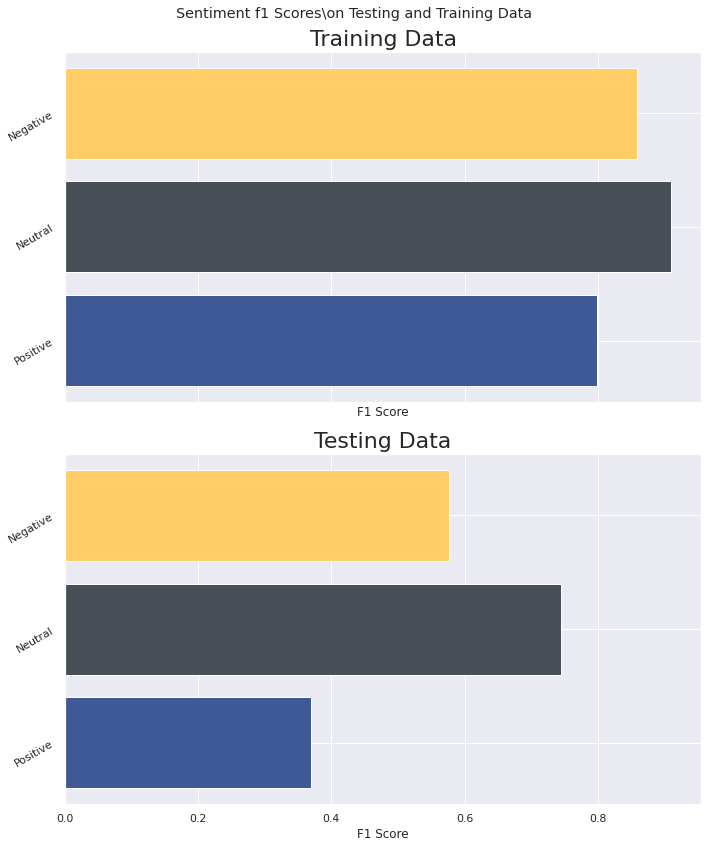

In [59]:
train_f1_scores = f1_score(train['sentiment'],    y_pred, average=None)
test_f1_scores  = f1_score( test['sentiment'], test_pred, average=None)

# sentiment_categories = sorted(np.unique(train['sentiment']))

colors = ['#3f5896', '#494f56', '#ffcc66']

fig, ax = plt.subplots(2,1,figsize=(10,12),sharex=True)

yticks_ = ['Positive','Neutral','Negative']

ax[0].barh(yticks_, train_f1_scores, color=colors)
ax[1].barh(yticks_,  test_f1_scores, color=colors)

ax[0].set(
    xlabel='F1 Score'
)
ax[1].set(
    xlabel='F1 Score'
)

ax[0].set_title(
    'Training Data',
    fontsize=22
)
ax[1].set_title(
    'Testing Data',
    fontsize=22
)

plt.suptitle('Sentiment f1 Scores\on Testing and Training Data')

for ax_ in ax:
    ax_.yaxis.set_tick_params(rotation=30)

plt.tight_layout()
'';

Our model looks pretty over-fit at this point. We're
getting about a 66% f1 score on our testing data, which
is pretty close to what our CV scores were earlier on
in the process. This may not be perfect, but it can
still give us some pretty reasonable insights into our
data and may make the process of hunting down problems
that the public is concerned about.

Let's take a look at something we found earlier -
entries that were marked as "I can't tell."

This isn't really something we can automatically verify
and score against without some extra data entry, but we
can subjectively gauge our model's effectiveness at a
cursory level.

In [60]:
rc_est = preprocess(reclassify['tweet_text'],sw)
rc_tfidf = tfidf.transform(rc_est)
rc_vec = pd.DataFrame(rc_tfidf.toarray(),columns=tfidf.get_feature_names())
reclassify['predicted_sentiment'] = best_model.predict(rc_vec)


In [61]:
rc_neu = reclassify[
    reclassify['predicted_sentiment']=='No emotion toward brand or product'
    ].sample(5)['tweet_text'].values
rc_neg = reclassify[
    reclassify['predicted_sentiment']=='Negative emotion'
    ].sample(5)['tweet_text'].values
rc_pos = reclassify[
    reclassify['predicted_sentiment']=='Positive emotion'
    ].sample(5)['tweet_text'].values

tweet_types = [
    ('Neutral tweets',rc_neu),
    ('Positive tweets',rc_pos),
    ('Negative tweets',rc_neg)]
md = []
nlc = '\n'
for type_ in tweet_types:
    header = f"\n\n<br/>\n<br/>\n\n | {type_[0]} |\n|---|"
    body = []
    for item_ in type_[1]:
        body.append(f"| {item_} |")
    md.append(f"{header}\n{nlc.join(body)}")

Markdown('\n'.join(md))



<br/>
<br/>

 | Neutral tweets |
|---|
| Looks like the line for the Apple pop-up store on Congress Ave is already down to the end of the block..  #SXSW #SteveJobsWins |
| How can google load those maps so fast, yet I can barely post a tweet haha #sxsw |
| Regardless of keyword - Google thinks local. #mobilesearch #SXSW #SXSWi |
| From #SXSW: @mention says @mention playing with NFC for next gen devices. Nexus S now, iPhone 5 next? |
| RT @mention Win an #OpenBeta6 iPad @mention this #sxsw panel {link}  today @mention 11! #usguys cc @mention  #DgtlTribe #sxswbuffalo |


<br/>
<br/>

 | Positive tweets |
|---|
| The session #designingforkids is changing my mind about my future kid's relationship with the iPhone. #sapient #sxsw |
| It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW |
| Comprando mi iPad 2 en el #SXSW (@mention Apple Store, SXSW w/ 62 others) {link} |
| Google Circles - looking forward to this. sadly no launch at #SXSW |
| I'll bet there's a lot of nerds at #SXSW using the #iPhone Light Saber app in barroom brawls instead of their fists. |


<br/>
<br/>

 | Negative tweets |
|---|
| TR @mention Google (tries again) to launch a new social network called Circles: {link} #sxsw {link} |
| The iPad 2 is the also a cartoonishly large digital camera. #SXSW #CStejas {link} |
| Apple is &quot;the classiest, fascist company in America,&quot; says @mention #sxsw |
| @mention RWW: Google Circles will be ______    #sxsw {link} |
| Bet on a GoogleBuzz-like #fail. People don't care about privacy, else they'd quitted FB/TW already RT @mention Google Circles will be __ #sxsw |

## Next Steps

To improve our model, we want to investigate a few more
items, including:
1. Analyzing brand information in our dataset to see if
adding context enhances model performance. 
2. We will also explore other modeling systems to
achieve better results
3. Consider non-English tweets
4. Implement an updating system that continuously
incorporates new and updated tweets, enabling the model
to adapt to evolving language context.

These steps will, hopefully, enhance the effectiveness
and generalization of our model to better predict tweet
sentiment.

For a reduced version of the process, the README file
is available
[here](./README.md).

Additionally, there is a copy of our presentation
[here, in pdf form](./twitter_sentiment.pdf).

For any questions or business inquiries, Max and JD are
available for contact through github and email.

### Contact Information

| Data Scientist | Github | email|
| ---: | --- | --- |
| JD | [https://github.com/ParkedHampster](https://github.com/ParkedHampster) | [jmentz@gmx.com](mailto:jmentz@gmx.com) |
| Max | [https://github.com/ImMaxRoss](https://github.com/ImMaxRoss) | [max@maxross.com](max@maxross.com) |

![thank_you_pic](./img/thank_you.png)

### File Structure

```bash
.
├── code
│  ├── __init__.py
│  ├── cleaner.py
│  ├── scoring.py
│  └── viz.py
├── data
│  ├── best_estimator.pkl
│  └── judge-1377884607_tweet_product_company.csv
├── img
│  ├── thank_you.png
│  └── twitter_title.png
├── LICENSE
├── README.md
├── scratch
│  ├── code -> ../code
│  ├── data -> ../data
│  └── img -> ../img
└── twitter_sentiment.ipynb
└── twitter_sentiment.pdf
```